In [1]:
%matplotlib inline

import matplotlib.pyplot as pl
import seaborn as sb
import numpy as np
from scipy.stats import norm

sb.set_style('darkgrid')
sb.set_context('notebook', font_scale=1.5)
blue, green, red, purple = sb.color_palette("deep",4)

## Signal Detection Theory and Simple Signal Detection

In the first notebook ([html](https://noahmotion.github.io/Signal%20Detection%20Theory%2C%20Part%201.html), [ipynb](https://github.com/noahmotion/noahmotion.github.io/blob/master/notebooks/sdt/Signal%20Detection%20Theory%2C%20Part%201.ipynb)), I talked about a few (mostly statistical) concepts that are important in signal detection theory (SDT), including likelihood ratios, Bayes rule, hits, false alarms, sensitivity, response bias, and the distinction between evidence for a signal and decision rules used to map ambiguous evidence to responses ("Yes, a signal was present" or "No signal was present").

All of this was presented in the context of a weird dice game, in which three dice are rolled, two of which are normal six-sided dice, the third of which has N sides with 0 pips and 6-N sides with 3 pips. The goal of the game is to determine whether the weird die showed 0 or 3 based on the total of the pips on all three dice.

This game is useful because it provides a relatively simple way to illustrate the concepts mentioned above. The major down side to the game is that it is not all that much like any real use of SDT.

This notebook will begin to explore a more realistic use of SDT in the context of a task requiring the detection of a signal in the presence of noise. To make things a bit more concrete, I will describe the use of SDT to model detection of a tone presented in white noise.

### A basic psychoacoustic experiment

In a basic tone-in-noise-detection task, on every trial a listener hears either noise alone or noise with a tone added. The relative frequency of noise-only and signal + noise trials (i.e., the prior probability of a tone) can be manipulated, but for now we'll assume that half the trials are noise-only and half are signal + noise. On each trial, the listener responds either "Yes" or "No", depending on whether she (thought she) heard a tone.

In this context, we (the experimenters) cannot directly observe either the internal evidence for the signal nor the listener's decision rule. We know (because we determine them ahead of time) the prior probability of a signal, the signal-to-noise ratio (SNR), and other properties of the signal tone (e.g., its duration and frequency).

We also know which trials were noise-only and which were signal + noise, and we know how the listener responded to each trial. This allows us to calculate hit and false alarm rates.

For example, suppose we designed the experiment to have 50 noise-only trials and 50 signal + noise trials, and our listener produced the following confusion matrix, where the rows correspond to the stimuli and the columns to responses:

|               | "No" | "Yes" |
|---------------|------|-------|
| noise-only    | 63   | 37    |
| signal + noise| 17   | 83    |

We can inspect the data and make some educated guesses about the listener's response bias and sensitivity to the signal. For both trial types, she was right more often than she was wrong, suggesting that she was reasonably sensitive to the (difference between the noise and the) signal. But there were more false alarms ("Yes" responses on noise-only trials) than there were misses ("No" responses on signal + noise trials), suggesting the the listener was at least mildly biased toward giving "Yes" responses.

### SDT as a latent variable model

If we are willing to make some assumptions about the listener's signal detection system and decision rule, we can adapt the basic structure of the weird-dice-game to model the data given above.

The most common two assumptions in SDT models of detection tasks like this are (1) noisy perceptual encoding and (2) deterministic response selection. The noisy perceptual encoding of noise-only and signal + noise stimuli is most often modeled using a pair of normal probability density functions ([PDFs](https://en.wikipedia.org/wiki/Probability_density_function)) defined over a latent (i.e., unobserved) perceptual evidence scale, and the response rule is typically modeled as a simple criterion on this scale. I will return to these assumptions in a later notebook.

The model of noisy encoding reflects the idea that some signal + noise trials provide strong evidence of a signal, while some produce only weak evidence, and most provide some middling degree of evidence. Similarly, some noise-only trials produce relatively strong perceptual evidence of a signal, others far less, with most providing some middling amount. Modeling  perceptual evidence on both types of trial as normally distributed random variables quantifies exactly how often noise-only and signal + noise trials produce exactly how much evidence.

Here is an illustrative example, in which the model of the distribution of perceptual effects for noise-only trials is normal with mean 0 and SD 1, and the model for signal + noise trials is normal with mean 1.75 and SD 1:

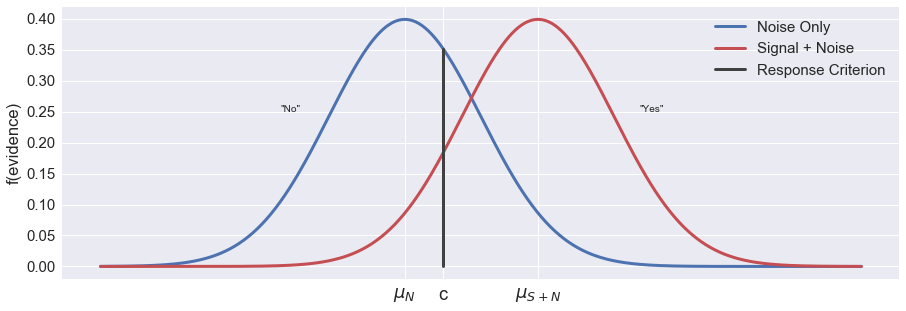

In [2]:
mu_N = 0; mu_S = 1.75; SD = 1
pe = np.linspace(-4, 6, 500) # perceptual evidence scale
fn = norm.pdf(pe, loc=mu_N, scale=SD) # noise-only perceptual distribution
fs = norm.pdf(pe, loc=mu_S, scale=SD) # signal + noise perceptual distribution
c = .5; ci = np.argmin(np.abs(pe-c)) # response criterion & index
fig, ax = pl.subplots(1, 1, figsize=(15,5))
ln, = ax.plot(pe, fn, color=blue, lw=3)
ls, = ax.plot(pe, fs, color=red, lw=3)
lc, = ax.plot([c,c], [0,fn[ci]], '-', lw=3, color=[.25,.25,.25])
ax.legend([ln,ls,lc],['Noise Only','Signal + Noise','Response Criterion'])
ax.text(mu_N-1.5, 0.25, '"No"', ha='center'); ax.text(mu_S+1.5, 0.25, '"Yes"', ha='center')
ax.set_xticks([mu_N, c, mu_S]); ax.set_xticklabels(['$\mu_N$','c','$\mu_{S+N}$'], fontsize=18)
ax.set(ylabel='f(evidence)');

In this model, sensitivity to the signal is reflected in the shift of the signal + noise perceptual distribution relative to the noise-only distribution, while response bias (or lack thereof) is reflected in the location of the response criterion. This model reflects a system that is moderately sensitive (the distributions only partially overlap) and biased toward "Yes" responses.

The model predicts hit, miss, false alarm, and correct rejection probabilities as the integrals of the appropriate distribution over the appropriate response region. So, for example, the predicted hit probability is the integral of the signal + noise distribution over the "Yes" response region, and the predicted false alarm probability is the integral of the noise-only distribution over the "Yes" response region:

$\begin{align*}
\Pr(\text{"Yes"} | \text{S+N}) &= \int_c^\infty f_{S+N}(x) dx\\
\Pr(\text{"Yes"} | \text{N}) &= \int_c^\infty f_N(x) dx\\
\end{align*}$

Here is a visualization of the integrals for the hit (shaded red) and false alarm (shaded blue) probabilities for this particular model:

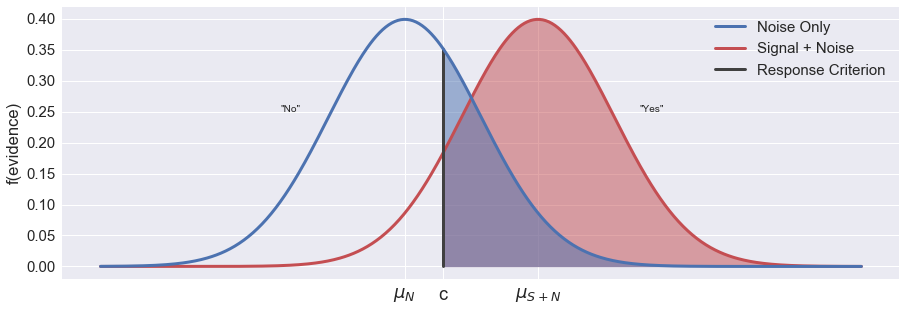

In [3]:
fig, ax = pl.subplots(1, 1, figsize=(15,5))
ls, = ax.plot(pe, fs, color=red, lw=3)
ax.fill_between(x=pe[ci:], y1=np.zeros(len(pe))[ci:], y2=fs[ci:], color=red, alpha=.5)
lc, = ax.plot([c,c], [0,fn[ci]], '-', lw=3, color=[.25,.25,.25])
ln, = ax.plot(pe, fn, color=blue, lw=3)
ax.fill_between(x=pe[ci:], y1=np.zeros(len(pe))[ci:], y2=fn[ci:], color=blue, alpha=.5)
ax.text(mu_N-1.5, 0.25, '"No"', ha='center'); ax.text(mu_S+1.5, 0.25, '"Yes"', ha='center')
ax.legend([ln,ls,lc],['Noise Only','Signal + Noise','Response Criterion'])
ax.set_xticks([mu_N, c, mu_S]); ax.set_xticklabels(['$\mu_N$','c','$\mu_{S+N}$'], fontsize=18)
ax.set(ylabel='f(evidence)');

We can calculate the exact predicted probabilities for this model:

In [4]:
pr_hit = norm.sf(c, loc=mu_S, scale=SD)
np.round(pr_hit,3)

0.894

In [5]:
pr_fa = norm.sf(c, loc=mu_N, scale=SD)
np.round(pr_fa,3)

0.309

These probabilities are reasonably close to the proportions given above as possible data, suggesting that this model would probably fit the data reasonably well, but they're not exactly right. The fake data had a hit probability of 0.83 and a false alarm probability of 0.37, but the model overestimates the hit probability and underestimates the false alarm probability.

Of course, we don't need to just guess at possible parameter values and compare predicted and observed response probabilities. With this basic SDT model and the simple $2\times 2$ confusion matrix, we can quickly and easily get estimates of both $c$ and $d'$, the response criterion and the shift in the signal + noise distribution (i.e., sensitivity).

Before doing so, I want to point out an important property of this model, namely that it is *translation invariant*. This means that if we shifted the whole model (i.e., both distributions and the response criterion) some fixed amount, either to the right or to the left, the predicted response probabilities would not change.

Setting the mean of the noise distribution equal to zero fixes the location of the whole model, which means, in part, that the other parameters ($c$ and $d'$) will be expressed relative to this point.

As illustrated above, $c$ is the lower limit of both the hit and false alarm integrals. Focusing just on the latter, we can use the [inverse](https://en.wikipedia.org/wiki/Quantile_function) [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and $1-\Pr(\text{"Yes"}|\text{N}) = \Pr(\text{"No"}|\text{N})$ (i.e., the correct rejection probability) to get an estimate of $c$ (expressed as a [$z$-score](https://en.wikipedia.org/wiki/Standard_score) relative to the mean of the noise distribution):

In [6]:
ph_hat = 83/100 # proportion of "Yes" responses on signal trials
pfa_hat = 37/100 # proportion of "Yes" responses on noise trials
c_hat = norm.ppf(1-pfa_hat) # inverse CDF of 1-Pr("Yes"|N)
np.round(c_hat,3)

0.332

Based on the "observed" false alarm probability, we estimate that the response criterion is about a third of standard deviation above the mean of the noise-only distribution.

Note that because of the symmetry of the normal PDF, the inverse CDF of the complement of probability $p$ is equal to the negative of the inverse CDF of $p$. Expressed mathematically, let $\Phi^{-1}(p)$ indicate the inverse normal CDF of $p$, then $\Phi^{-1}(1-p) = -\Phi^{-1}(p)$. And here is the same relationship illustrated with $p = \Pr(\text{"Yes"}|\text{N})$:

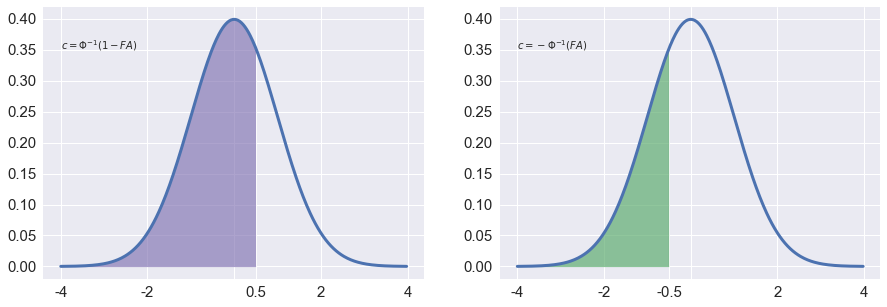

In [7]:
fig, axes = pl.subplots(1, 2, figsize=(15,5)); ax1, ax2 = axes;
ii = np.argmin(np.abs(pe-4)); cj = np.argmin(np.abs(pe+c))
ax1.plot(pe[:ii], fn[:ii], lw=3, color=blue)
ax1.fill_between(x=pe[:ci], y1=np.zeros(len(pe[:ci])), y2=fn[:ci], color=purple, alpha=0.65)
ax1.text(-4, .35, '$c=\Phi^{-1}(1-FA)$')
ax2.plot(pe[:ii], fn[:ii], lw=3, color=blue)
ax2.fill_between(x=pe[:cj], y1=np.zeros(len(pe[:cj])), y2=fn[:cj], color=green, alpha=0.65)
ax2.text(-4, .35, '$c=-\Phi^{-1}(FA)$')
ax1.set(xticks=[-4, -2, 0, c, 2, 4]); ax2.set(xticks=[-4, -2, -c, 0, 2, 4]);
ax1.set(xticklabels=[-4, -2, '', c, 2, 4]); ax2.set(xticklabels=[-4, -2, -c, '', 2, 4]);

We can also verify this with the `ppf()` method:

In [8]:
np.round(-norm.ppf(pfa_hat),3)

0.332

So, this is $c$ expressed relative to the mean of the noise distribution (i.e., 0). But along with the hit probability, the same point on the perceptual evidence scale also gives us information about $d'$. Specifically, $z = -\Phi^{-1}\big(\Pr(\text{"Yes"}|\text{S+N})\big)$ is an estimate of $c$ expressed as a $z$-score relative to the mean of the signal + noise distribution ($d'$).

In [9]:
z_hat = -norm.ppf(ph_hat)
np.round(z_hat,3)

-0.954

We can now get an estimate of $d'$ by noting that $c = d' + z$, or, rearranging terms and letting $\text{H}$ and $\text{FA}$ indicate hit and false alarm probabilities, respectively, $d' = c-z = \Phi^{-1}(\text{H}) - \Phi^{-1}(\text{FA})$. In this case, this means that:

In [10]:
d_hat = c_hat - z_hat
np.round(d_hat,3)

1.286

We could, if we like, stop here, since we have estimates of $c$ and $d'$. With these two parameters, we have a pretty reasonable characterization of the system in question.

This value of $d'$ indicates that the mean of the signal + noise distribution is about 1.3 SDs away from the mean of the noise-only distribution, indicating a moderately high degree of sensitivity.

However, although there is nothing incorrect about our estimate of $c$, it does not express response bias as fully as we might want it to. Note that a shift in a response criterion affects response to both types of trial. A shift to the left increases "Yes" responses across the board, while a shift to the right increases "No" responses across the board. Because $c$ is expressed only with respect to the noise distribution's location, it doesn't tell us anything about how it relates to the signal + noise distribution, so it is a suboptimal measure of response bias.

Because we now have an estimate of $d'$, though, we can use our estimate of $c$ to get a better measure of response bias.

One common measure of response bias is the likelihood ratio of the signal + noise and noise-only distributions at $c$, typically denoted $\beta$:

$\begin{equation*}
\beta = \displaystyle{\frac{f_{S+N}(c)}{f_N(c)} = \frac{\frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(c-\mu_{S+N})^2}{2\sigma^2}\right)}{\frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(c-\mu_{N})^2}{2\sigma^2} \right)} = \frac{\exp\left(-\frac{(c-\mu_{S+N})^2}{2}\right)}{\exp\left(-\frac{(c-\mu_{N})^2}{2} \right)}=\exp\left( \frac{(c-\mu_{N})^2}{2}-\frac{(c-\mu_{S+N})^2}{2} \right)}
\end{equation*}$

In [11]:
beta_hat = norm.pdf(c_hat, loc=d_hat)/norm.pdf(c_hat)
np.round(beta_hat,3)

0.67

If $\beta = 1$, then $c$ is at the point where $f_{S+N}(x)$ and $f_N(x)$ cross one another, and responses are unbiased. If $\beta < 1$, then $c$ is to the left of the crossover point, and there is a bias toward "Yes" responses, whereas if $\beta > 1$, then $c$ is to the right of the crossover, and there is a bias toward "No" responses.

Note that, because both distributions have equal SDs, this crossover point is $\frac{1}{2}d'$.

The likelihood ratio is a better measure of response bias than is $c$, but it has its own drawback. Chief among these is the fact that a likelihood ratio is compressed between 0 and 1 while it can increase to infinity above 1. Taking the log of a likelihood ratio helps with the asymmetry around 1.

So, if we take the log of $\beta$, we get:

$\begin{align*}
\log(\beta) &= \frac{1}{2}\left(c^2 - 2c\mu_N + \mu_N^2 - c^2 + 2c\mu_{S+N} - \mu_{S+N}^2 \right)\\
&= \frac{1}{2}\left( 2c\mu_{S+N} - \mu_{S+N}^2 \right)\\
&= c d' - \frac{1}{2}d'^2
\end{align*}$

If we then divide this by $d'$, we get a better measure of response bias, $b = \frac{\log(\beta)}{d'} = c - \frac{1}{2}d'$, which is the signed distance (in SD units) from the crossover point of the two perceptual distributions.

If $b=0$, there is no response bias, whereas begative $b$ indicates a bias toward "Yes" responses, and positive $b$ indicates a bias toward "No" responses. [Thomas (2001)](https://link.springer.com/article/10.3758%2FBF03194426?LI=true) ([pdf](https://www.researchgate.net/profile/Robin_Thomas2/publication/11903798_Perceptual_interactions_of_facial_dimensions_in_speeded_classification_and_identification/links/00b7d53bd4e9bbece0000000.pdf)) also notes that the statistical properties of this measure of response bias have been worked out a bit more than have the statistical properties of $\beta$.

Here is $b$ estimated from the fake data given above:

In [12]:
b_hat = c_hat - 0.5*d_hat
np.round(b_hat,3)

-0.311

I'll end this notebook with a brief discussion of the assumption of equal, unit variances in both perceptual distributions. I mentioned above that the noise-only distribution is typically fixed at 0 to set the location of the whole model.

In addition to being translation invariant, the model is also *scale* invariant, meaning that if we were to scale the whole model up or down, the predicted response probabilities would be preserved. We can set the variance of the noise-only distribution equal to one to fix the scale of the model.

But this doesn't address the assumption of equal variances in the two perceptual distributions. The presence of a signal in addition to noise might plausibly increase both the mean *and* the variance of the signal + noise distribution, pointing to a potential weakness of this model.

Perhaps unfortunately, the mean and variance of the signal + noise distribution are not identifiable when all we have is a $2 \times 2$ confusion matrix like the one given above.

First, note that by fixing the location and scale of the model, $c$ determines the predicted probabilities for noise-only trials.

Next, suppose the signal + noise distribution has mean $\mu_S$ and SD $\sigma_S \neq 1$. Then $\Pr(\text{"No"}|\text{S+N}) = \Phi\left( \displaystyle{\frac{c-\mu_S}{\sigma_S}} \right)$, and $\Pr(\text{"Yes"}|\text{S+N}) = 1-\Phi\left( \displaystyle{\frac{c-\mu_S}{\sigma_S}} \right)$, where $\Phi(x)$ is the standard normal CDF evaluated at $x$.

Two useful facts: If we transform a random variable $X$ with mean $\mu$ and variance $\sigma^2$ by multiplying it by $\alpha$ and adding $\delta$, then the expected value is $\alpha\mu + \delta$ and the variance is $\alpha^2\sigma^2$.

Using these facts, if we transform our signal + noise random variable by multiplying it by $\displaystyle{\frac{1}{\sigma}}$ and adding $c - \displaystyle{\frac{c}{\sigma}}$, the mean and variance of the transformed signal + noise random variable are $\displaystyle{\frac{\mu_S}{\sigma} + c - \frac{c}{\sigma} = c - \frac{c-\mu_S}{\sigma}}$ and $\displaystyle{\frac{\sigma^2}{\sigma^2}} = 1$, respectively.

Substituting these into the formula for $\Pr(\text{"No"}|\text{S+N})$ above, we get $\Phi\left( \displaystyle{c-\left(c-\frac{c-\mu_S}{\sigma_S}\right)} \right) = \Phi\left( \displaystyle{\frac{c-\mu_S}{\sigma_S}} \right)$.

All of which is to say that for any mean and non-unit variance in a signal + noise distribution, there is a scaled and shifted mean and unit variance that predict exactly the same response probabilities.

### Conclusion

The weird dice game from the first notebook is useful for illustrating SDT concepts, but in real-world uses of SDT, we generally know something about the physical properties of noise-only and signal + noise events, and we generally only observe responses of the system of interest to each type of event. Then we typically want to use the observed responses to draw inferences about the unobserved (and unobservable) properties of the signal detection system - sensitivity and response bias.

In this notebook, I illustrated how we can make some assumptions about the system (e.g., normally distributed perceptual evidence, a deterministic decision rule) to model the perceptual and response selection processes, and then use mathematical properties of this model to map observed hit and false alarm proportions to measures of sensitivity and bias.

In future notebooks, I will explore SDT models of some different tasks, fitting multilevel SDT models to data from multiple responders, and, in all likelihood, multidimensional generalizations of SDT, which is what I do for much of my actual research.